In [1]:
import time
start_time = time.time()

In [2]:
#import napari
import numpy as np
import h5py
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import random
from pystackreg import StackReg
from skimage import io
import glob
from skimage.filters import threshold_li
from skimage.filters import threshold_local
from skimage.morphology import disk, ball
#from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.filters.rank import mean_bilateral
from skimage.morphology import disk
from matplotlib.backends.backend_pdf import PdfPages
from skimage.transform import warp
from skimage.registration import optical_flow_tvl1, optical_flow_ilk
from skimage.filters import threshold_otsu, rank
from pystackreg import StackReg
import pickle as pkl
import re
import sys
import cv2
from datetime import date
import os, psutil
process = psutil.Process(os.getpid())

# Grab utilities from the imaging directories dir
utilsDir = re.sub(r'Registration', 'Imaging Utilities', str(sys.path[0]))

# Homebrew utilities for importing ims files & basic image manipulation
sys.path.append(utilsDir)
import ims_file_utils as ims
import image_processing_utils as impro
import plotting_funcs as plot

## Functions for the code

In [3]:
# Use this function to threshold images
def thresh(imgstk):
    th = threshold_li(imgstk)
    imgstk = imgstk>= th
    return imgstk

In [4]:
# This function is used for removing background post stitching Max-projection
def background_correction(max_img):
    max_img = max_img[~np.all(max_img == 0, axis=1)]
    max_img = max_img[:,~np.all(max_img == 0, axis=0)]
    return max_img

In [5]:
# Use this function for local thresholding of images
def lthresh(imgstk):
    th = threshold_local(imgstk, 45, offset=0)
    imgstk = imgstk>= th
    return imgstk

In [6]:
# Use this function for local thresholding of images
def lotsu(imgstk):
    th = rank.otsu(imgstk, disk(2))
    imgstk = imgstk>= th
    return imgstk

In [7]:
#Dumping images to pickle file
def picklewriter(imglist, filename):
    fname = open(filename,'wb')
    for i in range(0,len(imglist)):
        pkl.dump(imglist[i], fname)
    fname.close()

In [8]:
def attr_to_string(attr):
    # decodes an attribute from an ims file to a string
    attr_chararray = np.char.decode(attr.astype(np.bytes_), 'ASCII') 
    return ''.join(map(str, attr_chararray))

In [9]:
# For 2D registration
def max_proj_transform(rf_img, imgs, tmat1, tmat2):
    max_reg = []
    i = 0
    for cycle in imgs:
        chn = []
        for ch in range(0,cycle.shape[0]):
            print("Registering Cycle {}, Channel {}".format(i + 1, ch))
            reg = register_oflow(tmat1[i],tmat2[i], rf_img[:y,:x], cycle[ch,:y,:x])
            chn.append(reg)
        max_reg.append(np.asarray(chn))
        i = i+1
    return max_reg

In [10]:
def visualizer(reg_stack):
    viewer = napari.Viewer(ndisplay=3)
    for v in range(0,len(reg_stack)):
        viewer.add_image(reg_stack[v], rgb=False, name='cyc'+str(v),blending='additive')

In [11]:
def shift_image(image, w, h):
    height, width = image.shape[:2]
    T = np.float32([[1, 0, w], [0, 1, h]])
    img_translation = cv2.warpAffine(image, T, (width, height))
    return img_translation

In [12]:
def oflow(image0, image1):
    # --- Convert the images to gray level: color is not supported.
    image0 = rgb2gray(image0)
    image1 = rgb2gray(image1)

    # --- Compute the optical flow with Iterative Lucas Kanade
    #v, u = optical_flow_ilk(image0, image1, radius=20)
    # --- Compute the optical flow with TVL1
    v, u = optical_flow_tvl1(image0, image1)
    return v, u

In [13]:
def register_oflow(v,u,image0, image1):
    image0 = rgb2gray(image0)
    image1 = rgb2gray(image1)
    # --- Use the estimated optical flow for registration

    nr, nc = image0.shape
    
    row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc),
                                         indexing='ij')

    image1_warp = warp(image1, np.array([row_coords + v, col_coords + u]),
                       mode='nearest')
    return image1_warp

In [14]:
def imagevis(image0,thresh_proj,reg_stack):
    nr, nc = image0.shape
    pp = PdfPages(opdir+runName+'-registration.pdf')
    f, axarr = plt.subplots(1, 3)
    for c in range(0,len(thresh_proj)):
        image1 = thresh_proj[c][:nr,:nc]
        image1_warp = thresh(reg_stack[c][nuc_channel[c],:nr,:nc])
        # build an RGB image with the unregistered sequence
        seq_im = np.zeros((nr, nc, 3))
        seq_im[..., 0] = image1
        seq_im[..., 1] = image0
        seq_im[..., 2] = image0
        
        # build an RGB image with the registered sequence
        reg_im = np.zeros((nr, nc, 3))
        reg_im[..., 0] = image1_warp
        reg_im[..., 1] = image0
        reg_im[..., 2] = image0
        
        # build an RGB image with the registered sequence
        target_im = np.zeros((nr, nc, 3))
        target_im[..., 0] = image0
        target_im[..., 1] = image0
        target_im[..., 2] = image0
        
        # --- Show the result
        axarr[0].imshow(seq_im)
        axarr[0].set_title("Unregistered sequence")
        axarr[0].set_axis_off()
        
        axarr[1].imshow(reg_im)
        axarr[1].set_title("Registered sequence")
        axarr[1].set_axis_off()
        
        axarr[2].imshow(target_im)
        axarr[2].set_title("Target")
        axarr[2].set_axis_off()
        
        f.tight_layout()
        f.savefig(pp, format='pdf')
    pp.close()

## Body of the code

In [15]:
### VARIABLE DEFINITION ###
runName = '20230721_GFP_1'
maxpro = True # Set false if 3D registration required
pwd= '/mnt/disks/external/jg4159/20230721_GFP/'  # Path to input
interactive = False #If true will show napari visualizations
opdir = '/mnt/disks/external/jg4159/20230721_GFP/' # Path to output

In [16]:
#Loading ims files for different cycles
lof = glob.glob("/mnt/disks/external/jg4159/20230721_GFP/*_1_FusionStitcher.ims")
lof.sort()
cyc = []
#Make sure all files required are in the same directory
for f in lof:
    cyc.append(h5py.File(f, 'r'))
    print(f) #--- use this to verify if files are in order

/mnt/disks/external/jg4159/20230721_GFP/20230721_jg4159_GFP_R1_9_FusionStitcher.ims
/mnt/disks/external/jg4159/20230721_GFP/20230721_jg4159_GFP_R2_9_FusionStitcher.ims
/mnt/disks/external/jg4159/20230721_GFP/20230721_jg4159_GFP_R3_9_FusionStitcher.ims
/mnt/disks/external/jg4159/20230721_GFP/20230721_jg4159_GFP_R4_9_FusionStitcher.ims
/mnt/disks/external/jg4159/20230721_GFP/20230721_jg4159_GFP_R5_9_FusionStitcher.ims


In [17]:
a = list((cyc[0]['DataSetInfo'].keys()))
a.sort()
img_channels = []
print("Beginning Import")
for j in a[:-5]:
    em = attr_to_string(cyc[0]['DataSetInfo'][j].attrs['LSMEmissionWavelength'])
    print(em)
    if '405' in em:
        #print(em)
        ref_nuc_channel = int(j[-1])
    img_channels.append(cyc[0].get('DataSet/ResolutionLevel 1/TimePoint 0/'+j+'/Data'))
ref_img = np.asarray(img_channels)
#Converting 0 pixels to background intensity
#ref_img[ref_img == 0] = (np.bincount(ref_img.flat).argmax())
print("Import complete")

Beginning Import
640 nm
561 nm
405 nm
Import complete


In [18]:
print(ref_img.shape)

(3, 16, 4864, 4864)


In [19]:
#The following code is to get images from all channels and all cycles
# Order of data: Cycles[Channels[Z:Y:X]]
nuc_channel = []
img_cycles = []
for i in range(1,len(cyc)):
    a = list((cyc[i]['DataSetInfo'].keys()))
    a.sort()
    img_channels = []
    print("Beginning Import")
    for j in a[:-5]:
        em = attr_to_string(cyc[i]['DataSetInfo'][j].attrs['LSMEmissionWavelength'])
        print(em)
        if '405' in em:
            #print(em)
            nuc_channel.append(int(j[-1]))
        img_channels.append(cyc[i].get('DataSet/ResolutionLevel 1/TimePoint 0/'+j+'/Data'))
    img = np.asarray(img_channels)
    #Converting 0 pixels to background intensity
    #img[img == 0] = 100
    print("Import complete")
    img_cycles.append(img)

Beginning Import
640 nm
561 nm
405 nm
Import complete
Beginning Import
640 nm
561 nm
405 nm
Import complete
Beginning Import
640 nm
561 nm
405 nm
Import complete
Beginning Import
730 nm
488 nm
405 nm
Import complete


In [20]:
len(img_cycles)

4

In [21]:
print(img_cycles[0].shape)

(3, 16, 4864, 4864)


<Figure size 4320x2160 with 0 Axes>

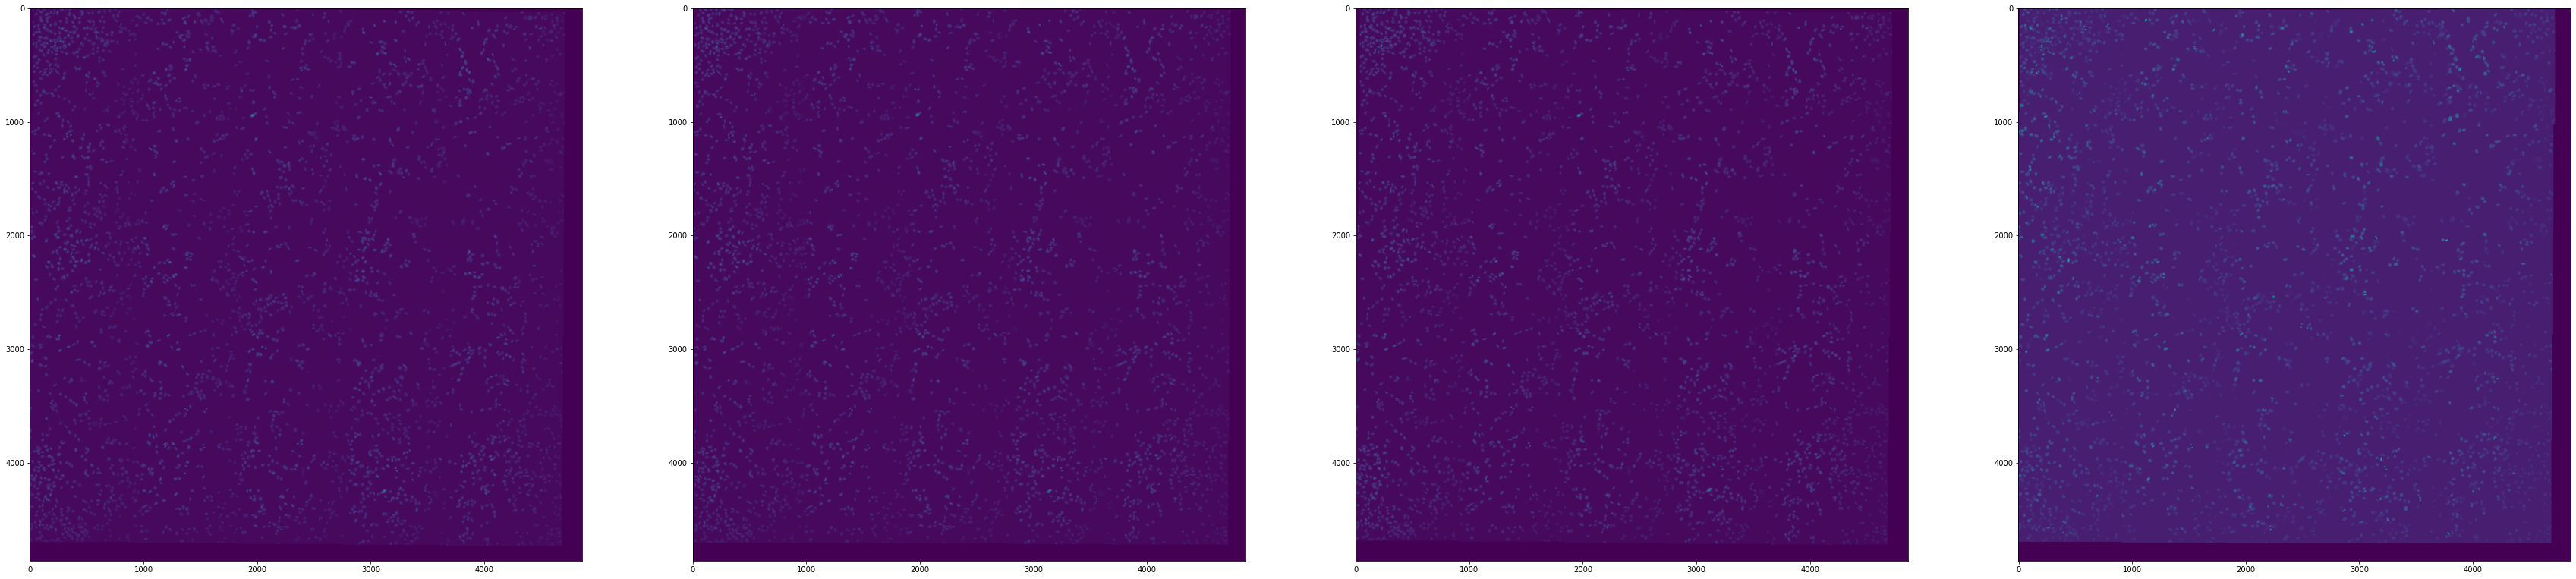

In [22]:
#Sanity check to see images imported correctly
plt.figure(figsize=(60, 30))
plt.rcParams['figure.figsize'] = [60, 30]
f, axarr = plt.subplots(1,len(img_cycles))
for c in range(0,len(img_cycles)):
    img  = img_cycles[c][nuc_channel[c]]
    axarr[c].imshow(np.max(img, axis=0))
    #plt.imshow(np.max(img, axis=0))

In [23]:
# manual thresholding
# from skimage.exposure import rescale_intensity
# ref_max_proj = np.max(ref_img[ref_nuc_channel,:,:,:], axis = 0)
# ref_thresh_proj = rescale_intensity(ref_max_proj, (250, 500), (0, 255))

In [24]:
# Getting max projection of nuclei for reference image (cycle 0)
ref_max_proj = np.max(ref_img[ref_nuc_channel,:,:,:], axis = 0)
#ref_max_proj = background_correction(ref_max_proj)
ref_thresh_proj = thresh(ref_max_proj)

# Getting max projection of nuclei for all readout cycles
max_proj = []
for i in range(0,len(img_cycles)):
    img  = img_cycles[i][nuc_channel[i]]
    max_proj.append(np.max(img, axis=0))
# Thresholding images of nuclei for all cycles
thresh_proj = []
i = 0
for max_pro in max_proj:
    #max_pro = background_correction(max_pro)
    thresh_proj.append(thresh(max_pro))
    #th = np.percentile(max_pro, 99.9)
    #max_pro = max_pro>= th
    #thresh_proj.append(max_pro)
    i = i+1

In [25]:
ref_max_proj.shape

(4864, 4864)

<Figure size 2160x1080 with 0 Axes>

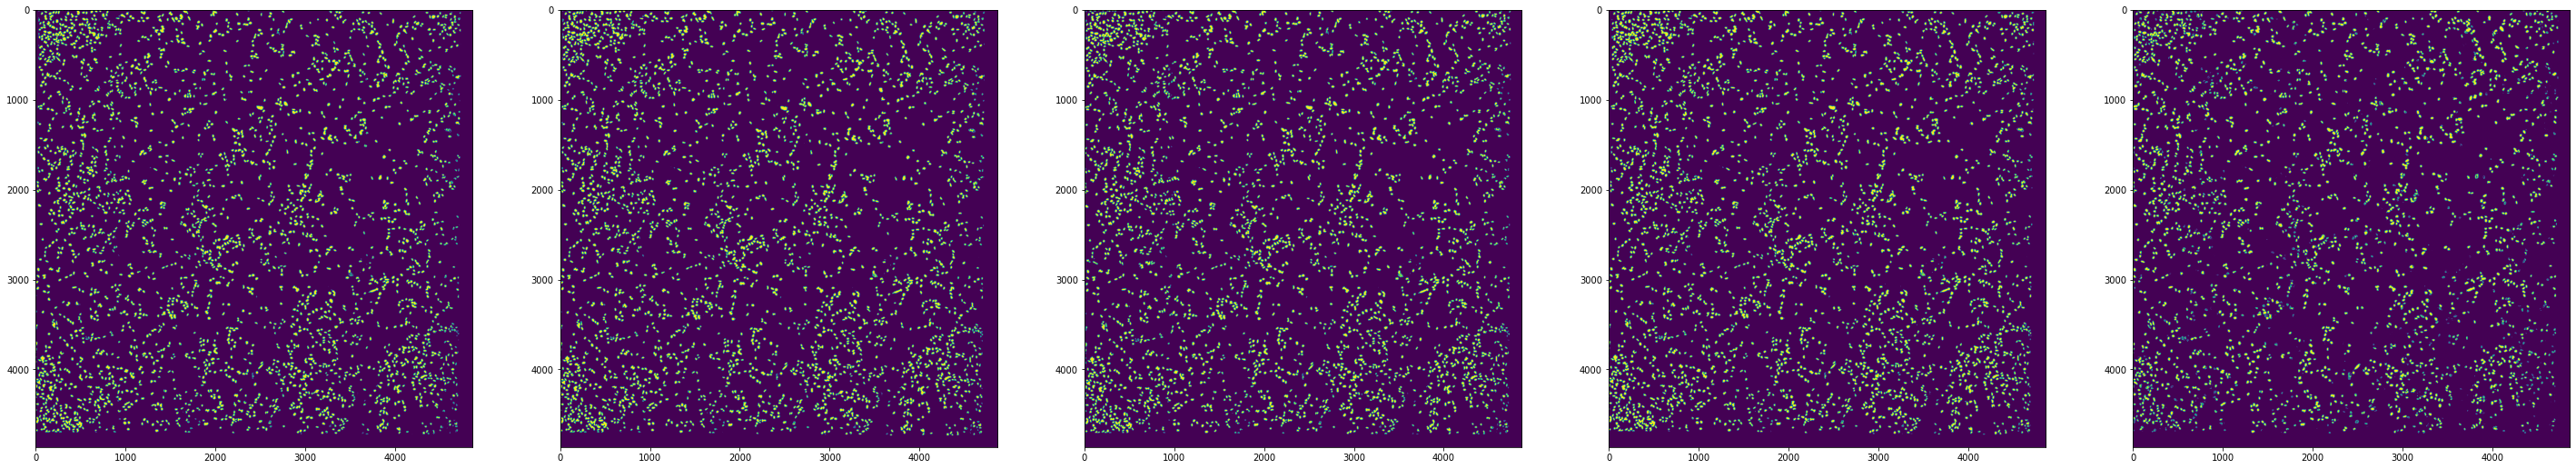

In [26]:
#Sanity check to see images thresholded correctly
plt.figure(figsize=(30, 15))
plt.rcParams['figure.figsize'] = [50, 30]
f, axarr = plt.subplots(1,len(thresh_proj)+1)
axarr[0].imshow(ref_thresh_proj)
for i in range(1,len(thresh_proj)+1):
    #print(thresh_proj[i-1].shape)
    axarr[i].imshow(thresh_proj[i-1])
    #plt.imshow(thresh_proj[i])

In [27]:
ref_thresh_proj.shape

(4864, 4864)

In [28]:
for i in range(len(thresh_proj)):
    print(thresh_proj[i].shape)

(4864, 4864)
(4864, 4864)
(4864, 4864)
(4864, 4864)


In [29]:
# Register the max projection of the nuclei using oflow
tmat1=[]
tmat2=[]
y = ref_thresh_proj.shape[0]
x = ref_thresh_proj.shape[1]
for c in range(0,len(thresh_proj)):
    #r = registration(ref_thresh_proj, thresh_proj[c][thresh_proj[c].shape[0]-y:,thresh_proj[c].shape[1]-x:])
    v, u = oflow(ref_thresh_proj[:y,:x], thresh_proj[c][:y,:x])
    tmat1.append(v)
    tmat2.append(u)

/mnt/disks/external/jg4159/.conda/envs/cellpose/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  This is separate from the ipykernel package so we can avoid doing imports until
/mnt/disks/external/jg4159/.conda/envs/cellpose/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  after removing the cwd from sys.path.


In [30]:
if maxpro == True:
    max_img = []
    for i in range(0,len(img_cycles)):
        max_img.append(np.max(img_cycles[i],axis=1))
    reg_stack = max_proj_transform(ref_thresh_proj,max_img, tmat1, tmat2)
else:
    reg_stack = zstack_transform(img_cycles, tmats)

Registering Cycle 1, Channel 0


/mnt/disks/external/jg4159/.conda/envs/cellpose/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  
/mnt/disks/external/jg4159/.conda/envs/cellpose/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  This is separate from the ipykernel package so we can avoid doing imports until


Registering Cycle 1, Channel 1
Registering Cycle 1, Channel 2
Registering Cycle 2, Channel 0
Registering Cycle 2, Channel 1
Registering Cycle 2, Channel 2
Registering Cycle 3, Channel 0
Registering Cycle 3, Channel 1
Registering Cycle 3, Channel 2
Registering Cycle 4, Channel 0
Registering Cycle 4, Channel 1
Registering Cycle 4, Channel 2


In [31]:
a = 0
for i in reg_stack:
    img = thresh(i[nuc_channel[a]])
    cm = np.corrcoef(ref_thresh_proj[:y,:x].flat, img.flat)
    print(cm[0,1])
    a=a+1

0.9948302878633325
0.993775735684195
0.9937444466938523
0.8983607048343211


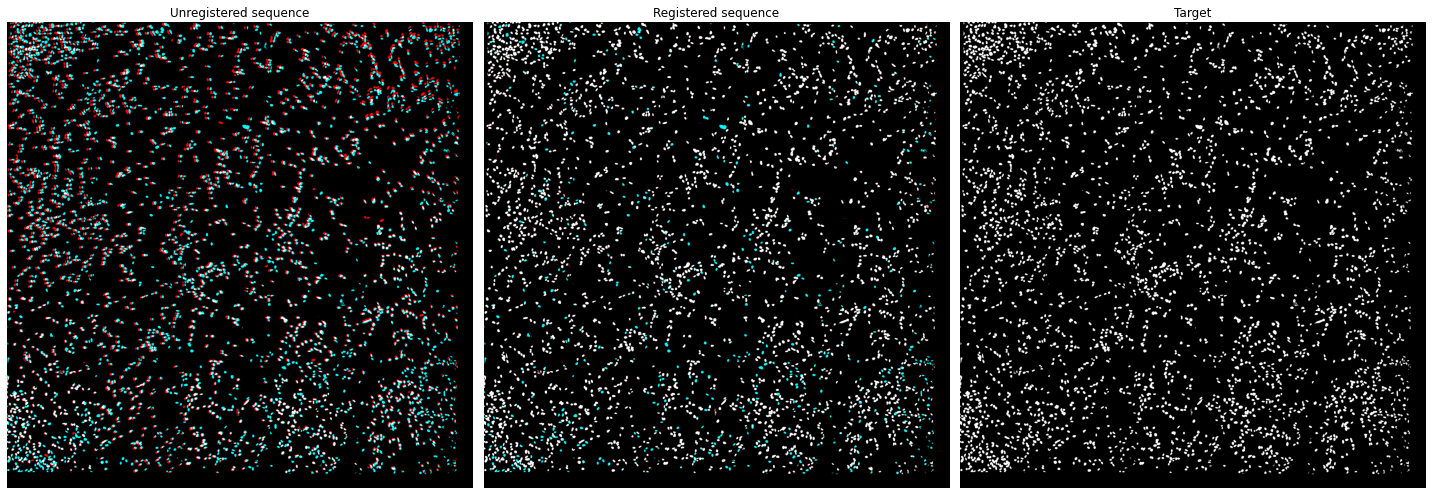

In [32]:
if interactive == True:
    visualizer(reg_stack)
else:
    plt.rcParams['figure.figsize'] = [20, 15]
    imagevis(ref_thresh_proj[:y,:x],thresh_proj,reg_stack)

In [33]:
reg_stack.insert(0, np.max(ref_img[:,:,:ref_thresh_proj.shape[0],:ref_thresh_proj.shape[1]],axis=1))

In [34]:
# Save max projection images for next step in pipeline
filehandler = open(opdir+'RegisteredImages_reverse_' + runName + '.pkl', 'wb')
pkl.dump(reg_stack, filehandler)
filehandler.close()

In [35]:
print(process.memory_info().rss/10**9)
print("--- %s seconds ---" % (time.time() - start_time))

21.77415168
--- 1794.805394411087 seconds ---
